# Experiment 6

## New scenario: Suikawari
https://en.wikipedia.org/wiki/Suikawari  

I made a new scenario 'suikawari' and checked its behavior.  
I also changed the scenario and checked how the agents changed their behavior.

### Rule (default: exp6.1)
There are two kinds of agents (speaker and splitter) and one goal (watermelon).  
Only the speaker knows the watermelon position so that he leads the splitter to  
the watermelon by his voice.  
The splitter is blind and can hear only the speaker's voice.

- speaker
    - observation: the direction to the watermelon from the splitter
    - action: voice (5 dim)
    - rew: -1 * distance between splitter and watermelon
- splitter
    - observation: speaker's voice
    - action: move (adding splitter's v)
    - rew: same as speaker


### Summary
XXXX

## Exp directories
### exp6-1: suikawari
- 6-1-1 (default)
    - suikawari1__2018-04-04_17-58-42
- 6-1-2 (maddpg -> ddpg)
    - suikawari1__2018-04-04_18-08-26

### exp6-2: suikawari2
- exp 6-1-1 (maddpg)
- exp 6-1-2 (maddpg -> ddpg)

### exp6-3: suikawari3
- exp 6-3-1
    - suikawari3__2018-04-03_19-33-03
- exp 6-3-2
    - suikawari4__2018-04-04_13-46-22
    
### exp6-4: suikawari4
- XXX


## Note
The movable agent's action is "adding its velociy".  
The agent can take five actions (four direction + one neutral):
- 1: right
- 2: left
- 3: up
- 4: down
- 0: neutral


In [2]:
%matplotlib inline
import os
import os.path as osp
import re
import glob
from IPython.display import HTML
from IPython.display import display
plt.rcParams["font.size"] = 16

exp_dir = '../exp_results/exp6_180331'
par_dir = '../params/'

def play_linked_video(each_exp_dir, fn_video, width=500, height=300):
    fn_video = _get_linked_video(each_exp_dir, fn_video)
    return _play_video(fn_video, width, height)

def _get_linked_video(each_exp_dir, fn_video):
    link_dir = osp.join('./videos', osp.basename(each_exp_dir))
    if osp.lexists(link_dir):
        os.remove(link_dir)
    os.symlink(osp.abspath(each_exp_dir), link_dir)
    fn_video = osp.join(link_dir, 'videos/%s' % fn_video)
    return fn_video

def _play_video(fn_video, width=500, height=300):
    print(fn_video)
    return HTML("""
    <video width="%d" height="%d" controls>
      <source src="%s" type="video/mp4">
    </video>""" % (width, height, fn_video))

def get_exp_dir(exp_dir, scenario):
    for fn in glob.glob(osp.join(exp_dir, '*')):
        if re.search(scenario + '__', fn):
            return fn

def get_scenario_df(exp_dir, scenario, fn_rewards):
    each_exp_dir = get_exp_dir(exp_dir, scenario)
    fn_lc = osp.join(each_exp_dir, 'learning_curves', fn_rewards)
    df_lc = pd.read_csv(fn_lc, index_col=False)
    return df_lc
    
def plot_each_lc(scenario):
    fn_lcs = ['rewards.csv', 'agents_rewards.csv']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for i, fn_rew in enumerate(fn_lcs):
        df_lc = get_scenario_df(exp_dir, scenario, fn_rew)
        df_lc.plot(x='step', style='-o', fontsize=16, ax=axes[i], title=scenario, alpha=0.5)

def plot_each_lc2(each_exp_dir):
    fn_lcs = ['rewards.csv', 'rewards.csv', 'agents_rewards.csv']
    
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))
    for i, fn_rew in enumerate(fn_lcs):
        fn_lc = osp.join(each_exp_dir, 'learning_curves', fn_rew)
        df_lc = pd.read_csv(fn_lc, index_col=False)
        df_lc.columns = [coln.strip() for coln in df_lc.columns]
        if i == 0:
            df_lc['step_per_epi'] = df_lc[['step']].diff().values / df_lc[['episode']].diff().values
            df_lc.plot(x='episode', y='step_per_epi', style='-o', fontsize=12, 
                               ax=axes[i], title=osp.basename(each_exp_dir), alpha=0.5)
        else:
            del df_lc['step']
            df_lc.plot(x='episode', style='-o', fontsize=12, ax=axes[i], title=osp.basename(each_exp_dir), alpha=0.5)
    #     break

def action_space(scenario):
    from multiagent.environment import MultiAgentEnv
    import multiagent.scenarios as scenarios
    fn = osp.join('../../../multiagent-particle-envs/multiagent/scenarios/%s.py' % scenario)
    scenario = scenarios.load(fn).Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    print(env.action_space)

In [3]:
def _make_dic():
    import string
    abc = string.ascii_uppercase
    if False:
        dic = dict(zip(abc, range(1, len(abc)+1)))
        dic['_'] = 0
    else:
        dic = dict(zip(abc, range(0, len(abc))))
    return dic

def to_case_val(case):
    dic = _make_dic()
    return dic[case]

def to_val_case(val):
    dic = _make_dic()
    dic_rev = dict([(v, k) for k, v in dic.items()])
    return dic_rev[val]

def get_df_messages2(fn_video):
    fn_message = fn_video.replace('.mp4', '_messages.csv')
    df_msg = pd.read_csv(fn_message)
    for coln in df_msg.columns[:-2]:
        if np.all(df_msg[coln] == '_'):
            del df_msg[coln]
        else:
            df_msg[coln] = df_msg[coln].apply(to_case_val)
    return df_msg

def plot_messages2(fn_video):
    df_msg = get_df_messages2(fn_video)
    each_epis = sorted(df_msg.episode.unique())
    fig, axes = plt.subplots(1, len(each_epis), figsize=(7*len(each_epis), 5), sharey=True)

    yticks = range(int(df_msg.iloc[:, :-2].values.max()) + 1)
    for i, i_epi in enumerate(each_epis):
        ax = axes[i]
        df_msg.loc[df_msg.episode==i_epi, df_msg.columns != 'episode']\
            .plot(x='step', style='-o', ax=ax,
                     alpha=0.5, title='i_epi=%d' % i_epi)
        ax.set_yticks(yticks)
        ax.set_yticklabels([to_val_case(v) for v in yticks])
    plt.subplots_adjust(wspace=0.05, hspace=0)

In [49]:
def plot_actions(epi, fn_video_template, n_episdoes=3, n_agents=2, n_dim_c=5):
    n_each_step = 50
    colns = ['act%d' % i for i in range(n_dim_c)]
    dic_act = dict(zip(colns, list(range(n_dim_c))))
    ylabels = ["speaker's voice", 'action']
    colors = ['grey', 'salmon', 'steelblue']
    
    fn_video = _get_linked_video(each_exp_dir, fn_video_template.format(epi))
    dfs = []
    for i in range(n_agents):
        fn_csv = fn_video.replace('.mp4', '_actions_agent%d.csv' % i)
        dfs.append(pd.read_csv(fn_csv))

    fig, axes = plt.subplots(2, 1, figsize=(28, 8), sharex=True)
    plt.subplots_adjust(hspace=0)
    epis = [i+1 for i in range(n_episdoes)]
    for i, df in enumerate(dfs):
        color = colors[i]
        i = min(i, 1)
        ax, ylabel = axes[i], ylabels[i]
        df.loc[df.episode.isin(epis), colns].rename(columns=dic_act).idxmax(axis=1).plot(style='-o', ax=ax, color=color)
        ax.set_ylabel(ylabels[i])
        if i == 0:
            yticks = list(range(n_dim_c))
            ax.set_yticks(yticks)
            ax.set_yticklabels([to_val_case(v) for v in yticks])
        else:
            yticks = list(range(5))
            dic_action = {0: 'n', 1: 'r', 2: 'l', 3: 'u', 4: 'd'}
            ax.set_yticks(yticks)
            ax.set_yticklabels([dic_action[v] for v in yticks])
        for i in range(n_episdoes):
            end_epi = (i + 1) * n_each_step - 1
            ax.axvline(end_epi, color='orange', ls='--')

## exp 6-1
This is a default scenario. The rule is explained in the header.

### exp6-1-1 (default)
#### Results
As expected, the splitter learns how to move by speaker's voice.  
Actually, I found the following releation (Speaker's voice (char) and the meaning):
- A: go down
- B: go left
- C: stay (you are around the goal!)
- D: go right
- E: go up

#### Discussion
After reaching the watermelon, the splitter got "C" from the speaker,  
which means that splitter are around the watermelon and he should stay there.  
But the splitter doesn't stop on the watermelon (the highest reward).  
This is because he doesn't know its velociy so that he cannot know which action  
will stop him.  
It looks that the splitter learns to take the random action when he gets "C".


### exp6-1-2 (MADDPG -> DDPG)
In exp6-1-1, MADDPG is used. In this case, the splitter's Q funcion is trained  
using the speaker's observation, where the direction to the watermelon is known.  
This makes the agents learn easily (3000~5000 episodes are enough to learn).  

In this experiment, we use DDPG instead of MADDPG.  
The splitter cannot get the goal info even during the training.

#### Results
The splitter learns how to move by speakers' voice　as like exp6-1-1.  
Compered with exp 6-1-1, however, the splitter doesn't move efficiently.  

#### Discussion
The learning curve shows that DDPG needs much more training episodes than MADDPG.  
In addition, even after the 10,000 epi training, the agents's movement is less efficient  
than exp6-1-1.

The splitter initially moves in the direction to the watermelon.  
But he cannot stay around the watermelon. Acutually, unlike exp6-1-1,  
it seems that there is no speaker's voice of "stay" in this exp.

In this sceario, MADDPG is a very efficient way to train.  
Because the goal position is known for all the agents during the training,   
the training is kind of "surpervised learning", which bridges the speaker'voice and  
splitter's intepretation efficiently.


## 6-1-1 (default)

None

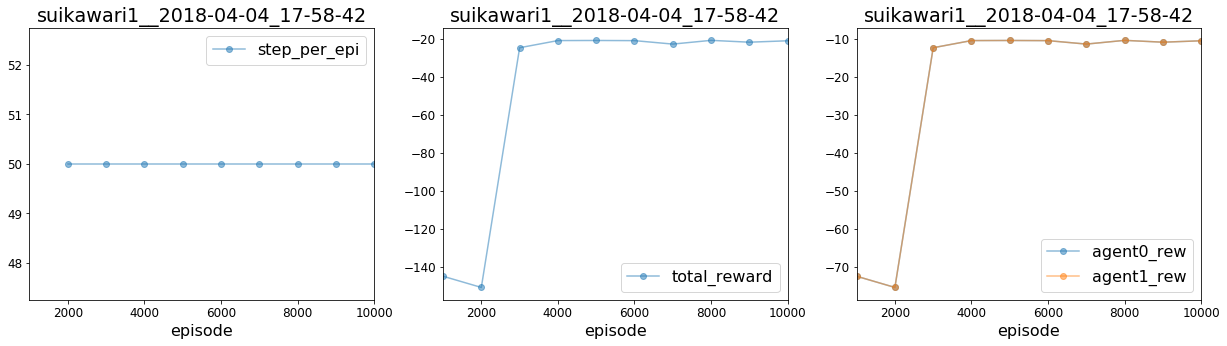

./videos/suikawari1__2018-04-04_17-58-42/videos/video-10000.mp4


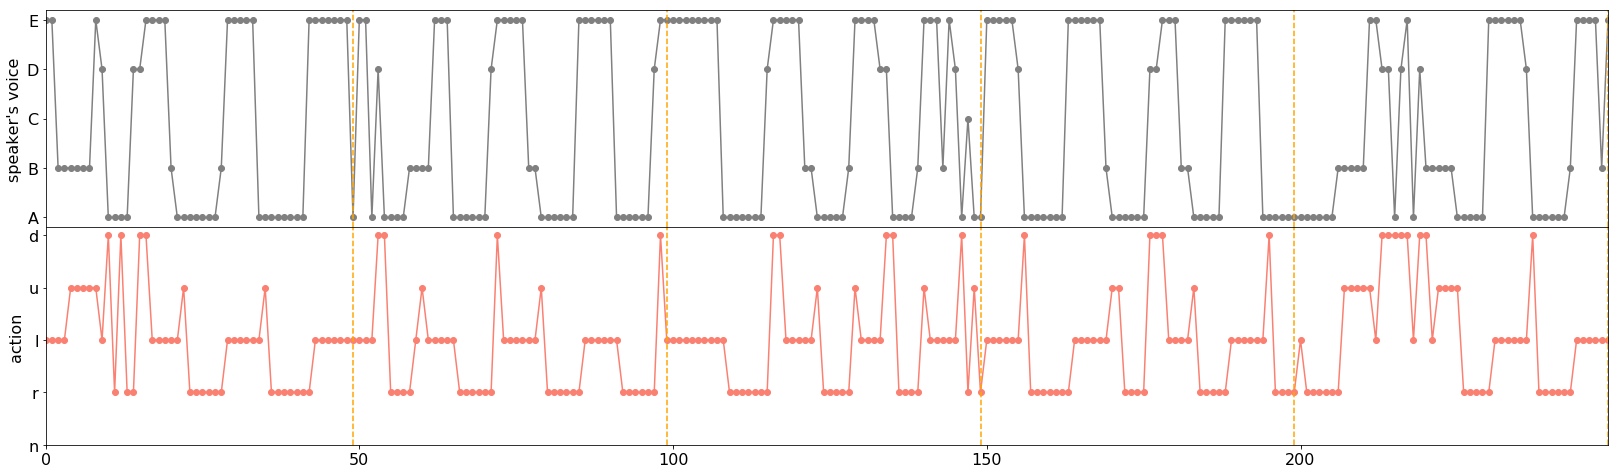

In [58]:
# 1st row: max_epi_len history + learning curve
# 2nd: row: video
# 3rd row: speaker's voice (5 char) + the corresponding action of the splitter
each_exp_dir= 'suikawari1__2018-04-04_17-58-42'
fn_video_template = 'video-{}.mp4'
epis = [10000]

each_exp_dir = osp.join(exp_dir, each_exp_dir)
display(plot_each_lc2(each_exp_dir))
plt.show()

for epi in epis:
    fn_video = fn_video_template.format(epi)
    display(play_linked_video(each_exp_dir, fn_video))
    plot_actions(epi, fn_video_template, n_episdoes=5)
    plt.show()

## 6-1-2 (MADDPG -> DDPG)

None

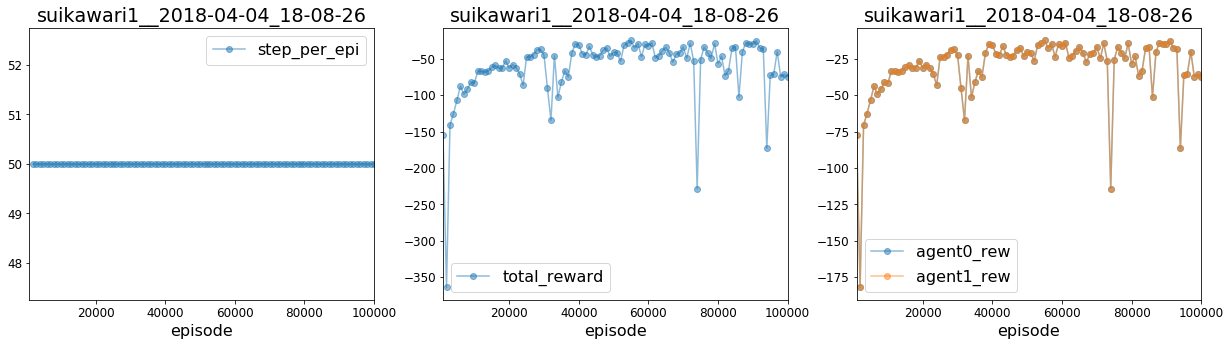

./videos/suikawari1__2018-04-04_18-08-26/videos/video-30000.mp4


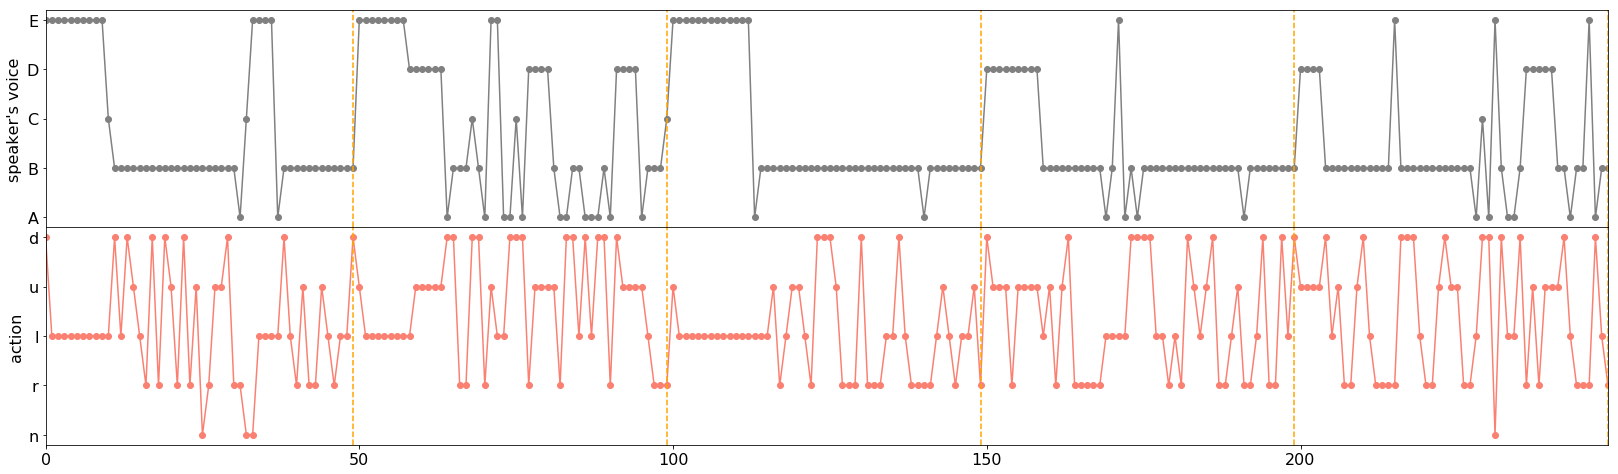


./videos/suikawari1__2018-04-04_18-08-26/videos/video-90000.mp4


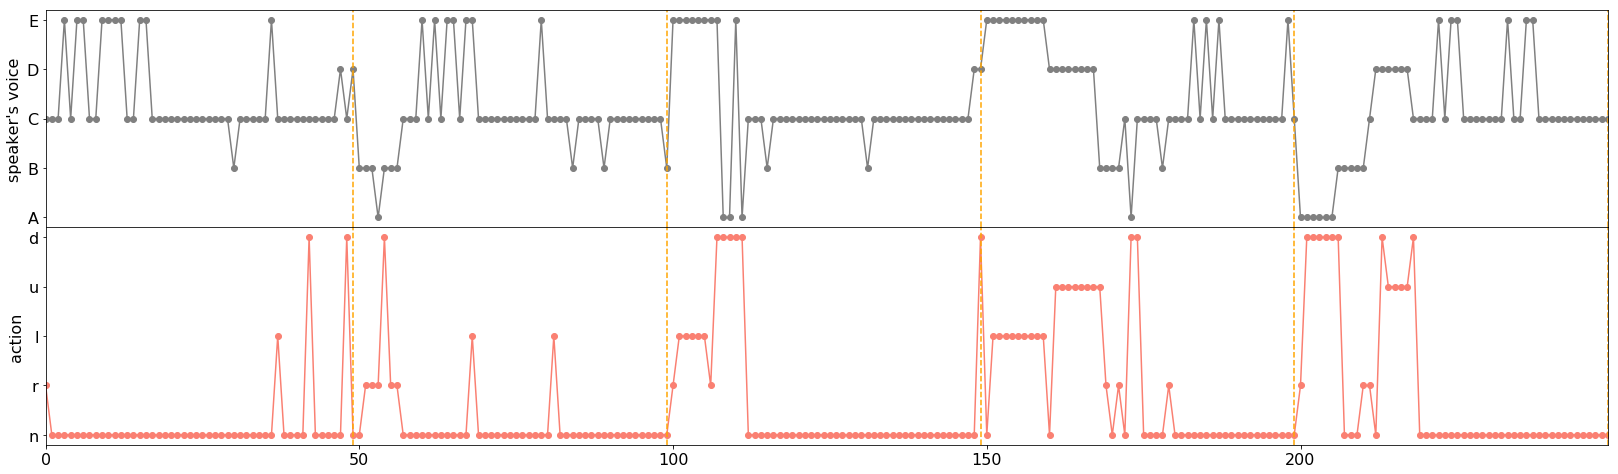


./videos/suikawari1__2018-04-04_18-08-26/videos/video-100000.mp4


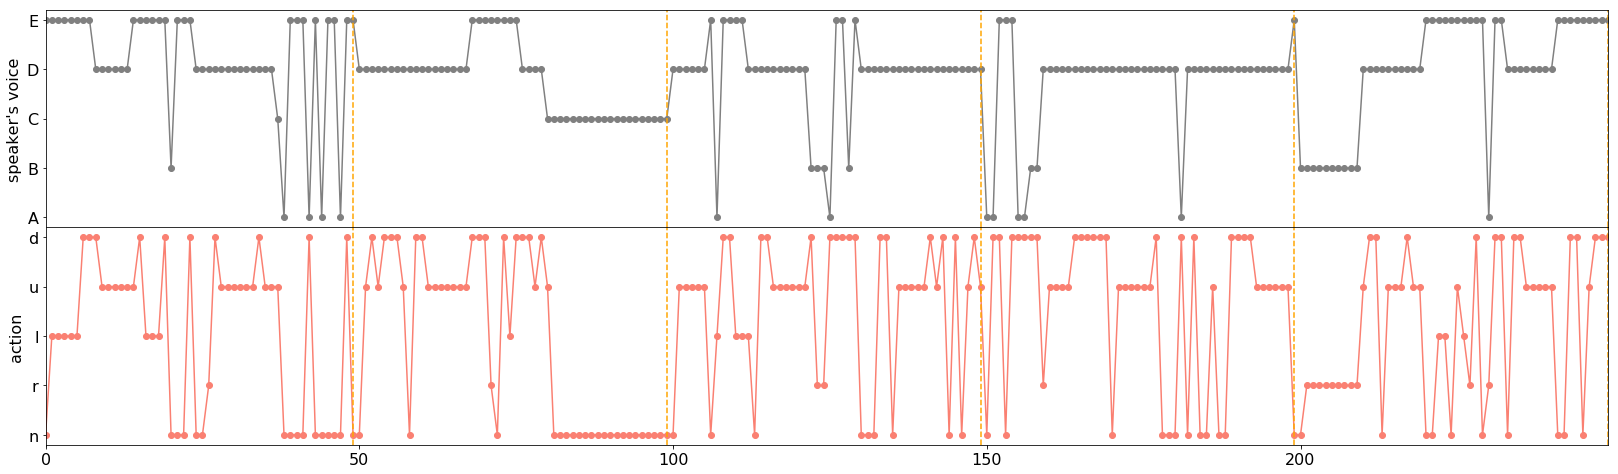

In [59]:
# 1st row: max_epi_len history + learning curve
# 2nd: row: video
# 3rd row: speaker's voice (5 char) + the corresponding action of the splitter

each_exp_dir= 'suikawari1__2018-04-04_18-08-26'
fn_video_template = 'video-{}.mp4'
epis = [30000, 90000, 100000]

each_exp_dir = osp.join(exp_dir, each_exp_dir)
display(plot_each_lc2(each_exp_dir))
plt.show()

for epi in epis:
    fn_video = fn_video_template.format(epi)
    display(play_linked_video(each_exp_dir, fn_video))
    plot_actions(epi, fn_video_template, n_episdoes=5)
    plt.show()
    print('=' * 100 + '\n')

## exp 6-2 (suikawari2)

### Background
In exp6-1 discussion, I concluded that the unstable movement around the watemelon is becuase  
the splitter cannot know how to stop.  
To help him, this exp tells the splitter his velocity. I expect this will make the splitter stay around  
the watermelon efficiently.

### Rule
The rule is the same as exp6-1 except that the splitter's velocity is added to his obvservation.

### exp 6-2-1 (MADDPG)
The learning curve shows that the reward significantly improves.  
The epi-40,000 results show that I couldn't find the simple relationship between voice and action  
(unlike exp 6-1).  
The results are what I expect! The agents efficiently learn but the learning results is difficult to  
interpret by human. This suggests that the machine could surpass human's ability.

In any case, I try to find the realtioinship from the video.
- A down (right down?)
- B: stay (but sligtly go left down)
- C: go right
- D: go down
- E: go (right) up?

As stated above, the splitter now has the splitter's velocity parameter, it is difficult to clearly  
interpret the speakers' voice meaning. Some of voice (C, D) seems directly connected to the action.  
Although the others depends on the velocity and I couldn't find a clear relationship, "B" seems  
"stay" in this experiment. But it is not a clearcut "stay" (slightly going left down?) so that  
sometimes "A" and "E" tune the splitter's poisition.

### exp 6-2-2 (DDPG)
The learning looks worse than exp6-1-2 (the splitter doesn't learn the lateral motion).  
This might be because more input information makes the learning unstable.


## 6-2-1 (MADDPG)

None

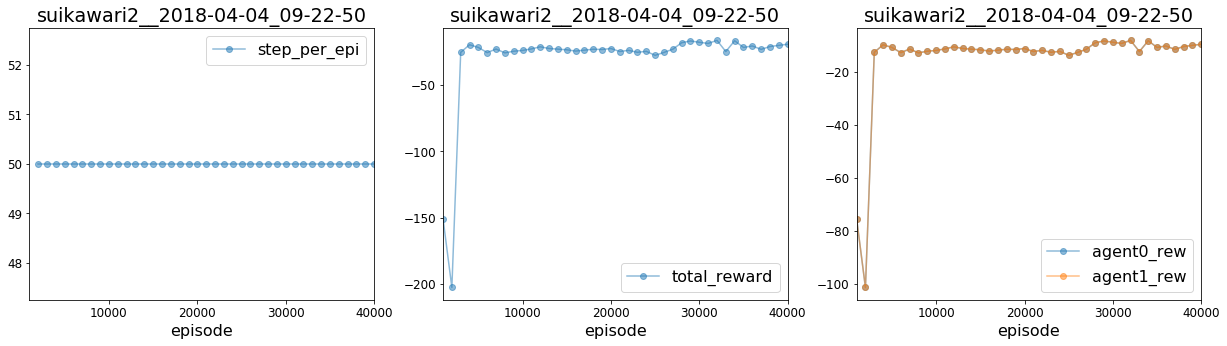

./videos/suikawari2__2018-04-04_09-22-50/videos/video-40000.mp4


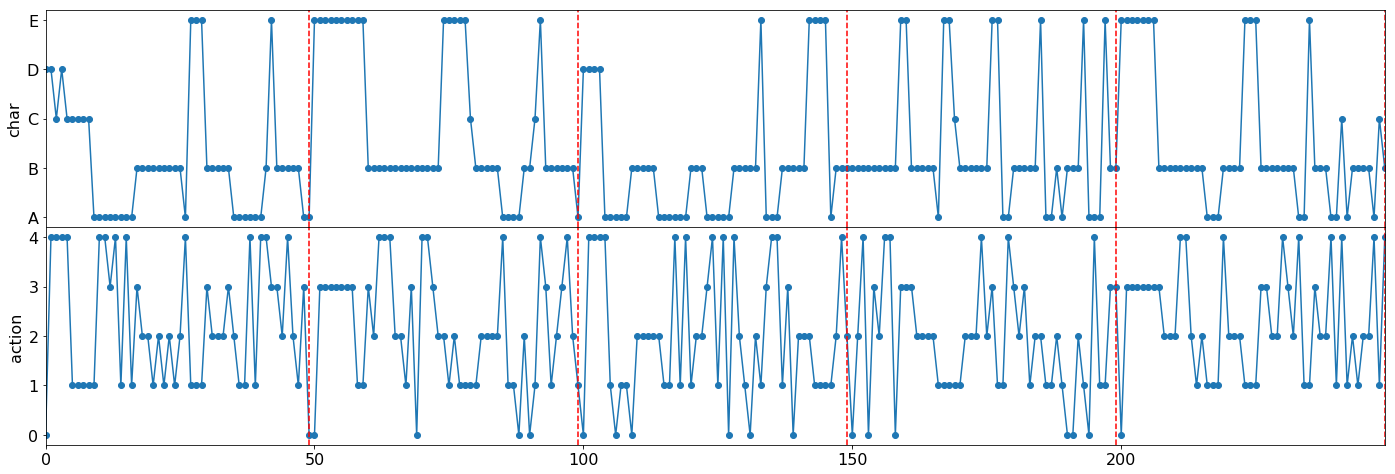

In [18]:
each_exp_dir= 'suikawari2__2018-04-04_09-22-50'
fn_video_template = 'video-{}.mp4'
epis = [40000]

each_exp_dir = osp.join(exp_dir, each_exp_dir)
display(plot_each_lc2(each_exp_dir))
plt.show()

for epi in epis:
    fn_video = fn_video_template.format(epi)
    display(play_linked_video(each_exp_dir, fn_video))
    plot_actions(epi, fn_video_template, 5)
    plt.show()

## 6-2-2 (MADDPG -> DDPG)

None

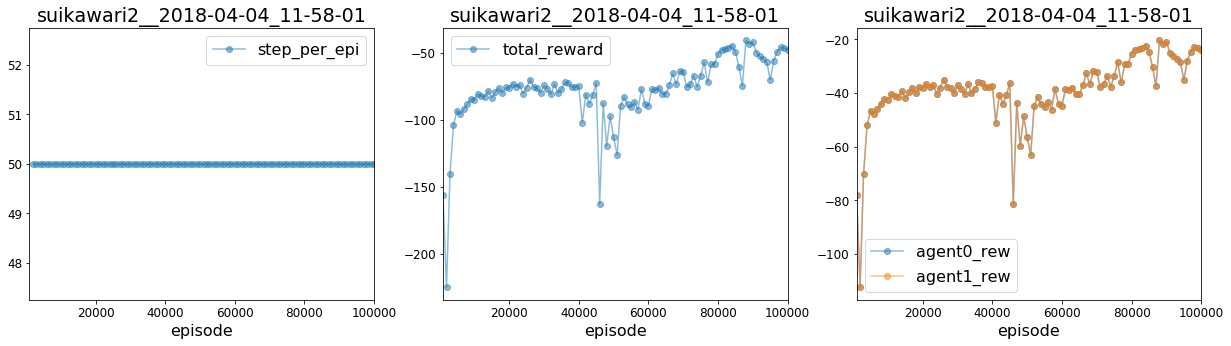

./videos/suikawari2__2018-04-04_11-58-01/videos/video-100000.mp4


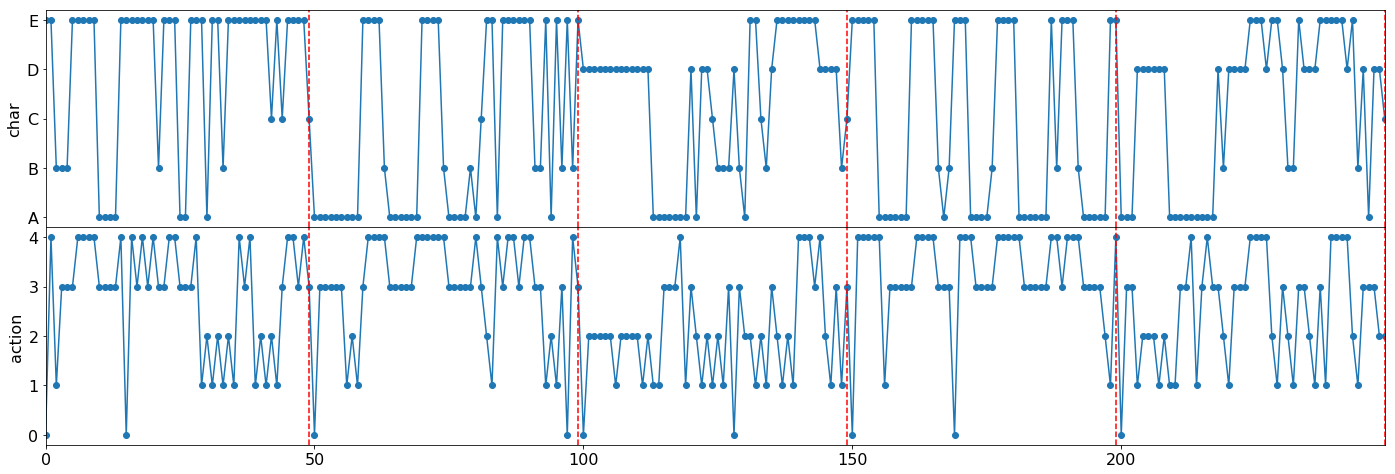

In [20]:
each_exp_dir= 'suikawari2__2018-04-04_11-58-01'
fn_video_template = 'video-{}.mp4'
epis = [100000]

each_exp_dir = osp.join(exp_dir, each_exp_dir)
display(plot_each_lc2(each_exp_dir))
plt.show()

for epi in epis:
    fn_video = fn_video_template.format(epi)
    display(play_linked_video(each_exp_dir, fn_video))
    plot_actions(epi, fn_video_template, 5)
    plt.show()

## exp 6-3 (suikawari3, suikawari4)

### exp 6-3-1 (suikawari3)
#### Rule
Almost same as exp 6-1.  
The differences are:
- the number of splitters is 2 (exp6-1 is 1)
- the speaker's char dimension is set at 6 (5 at exp6-1)
- In addiction to the goal position from each agent, the splitters' velocity is added to the speaker's obs.

#### Results
The agents properly + rapidly (~ 5000 epi) learn how to speak and move.

#### Discussion
I expected that this was a difficutl task. But the results shows that this is an easy one  
for the machine. This is excting!  
The figure of the speaker's voice and the correspoinding action implies that no-clear relationship  
between the voice and splitter's actoins. This is probably because the splitter's input is a direct speaker's output.  
The each element of the speaker's output vector can take 0--1 (sum of the element = 1.0).  
Therefore the output can have more information than just one character (e.g., A, B, C...).

### exp 6-3-2 (suikawari4)
#### Background
Based on the above discussion, we try one-hot input instead of an "analog" vector.

#### Rule
The same as suikawari3 except that the observation of the splitters are one-hot vector  
instead of a direct speaker's output.

#### Results
Like as exp6-3-1, the agents properly + rapidly (~ 5000 epi) learn how to speak and move.  
But unlike exp6-3-1, the figure of the speaker's voice and the correspoinding action shows  
a clear relationship between the voice and the movement:
- **agent1 (red)**
    - A: go up
    - B: go down
    - C: go right
    - D: go left
    - E: go left
    - F: go right
- **agent2 (blue)**
    - A: unclear (random + neutral?)
    - B: go down
    - C: go up
    - D: go left
    - E: go up
    - F: go right

#### Discussion
The speaker's voice is diffrently interpreted by each agent (e.g., "C" means "go right" for agent1  
and "go up" for agent2). Using this trick, the speaker manages both agents to get close to the watermelon.  
I also found that there is no "stay" but there is a redundant order. For example, "C" and "F" mean "go up" and  
"go right" respectively for agent2; but both the voice mean "go right" for agent1.   
This is also helpful to make the splitters move differently.

## exp 6-3-1 (suikawari3)

None

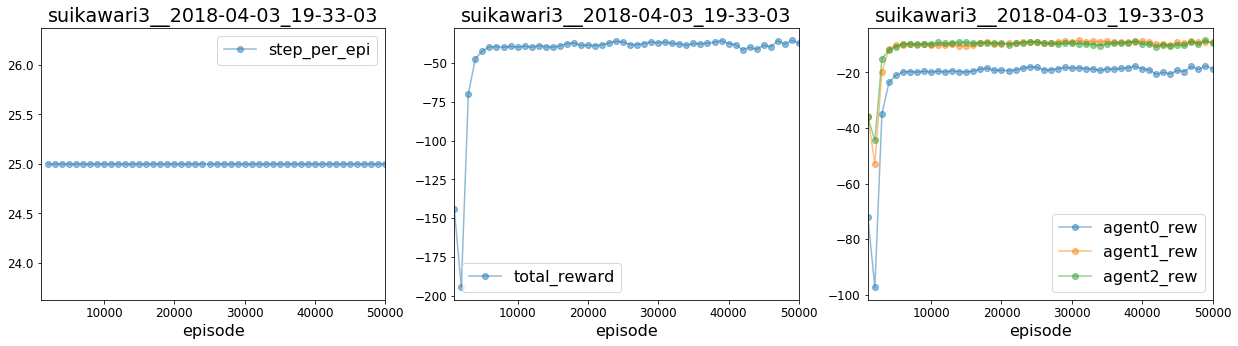

./videos/suikawari3__2018-04-03_19-33-03/videos/video-50000.mp4


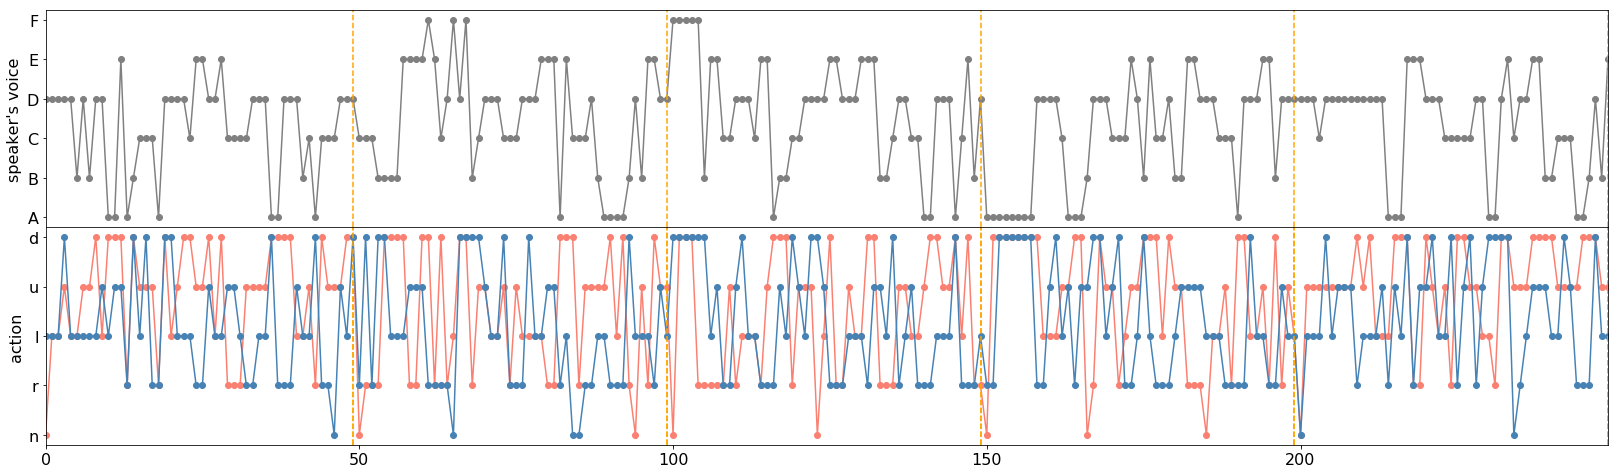

In [51]:
# 1st row: max_epi_len history + learning curve
# 2nd: row: video
# 3rd row: speaker's voice (6 char) + the corresponding action of the splitter (red=red agent, blue=blue agent)
each_exp_dir= 'suikawari3__2018-04-03_19-33-03'
fn_video_template = 'video-{}.mp4'
epis = [50000]

each_exp_dir = osp.join(exp_dir, each_exp_dir)
display(plot_each_lc2(each_exp_dir))
plt.show()

for epi in epis:
    fn_video = fn_video_template.format(epi)
    display(play_linked_video(each_exp_dir, fn_video))
    plot_actions(epi, fn_video_template, n_episdoes=5, n_agents=3, n_dim_c=6)
    plt.show()

## exp 6-3-2 (suikawari4)

None

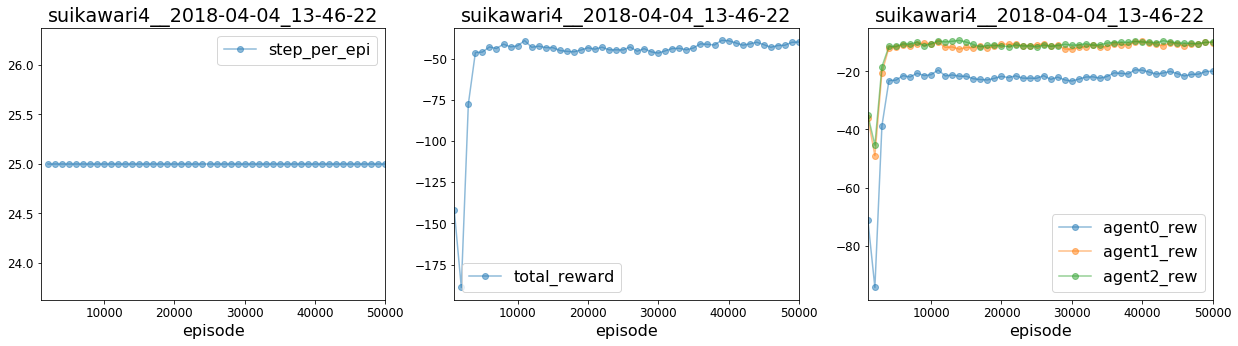

./videos/suikawari4__2018-04-04_13-46-22/videos/video-50000.mp4


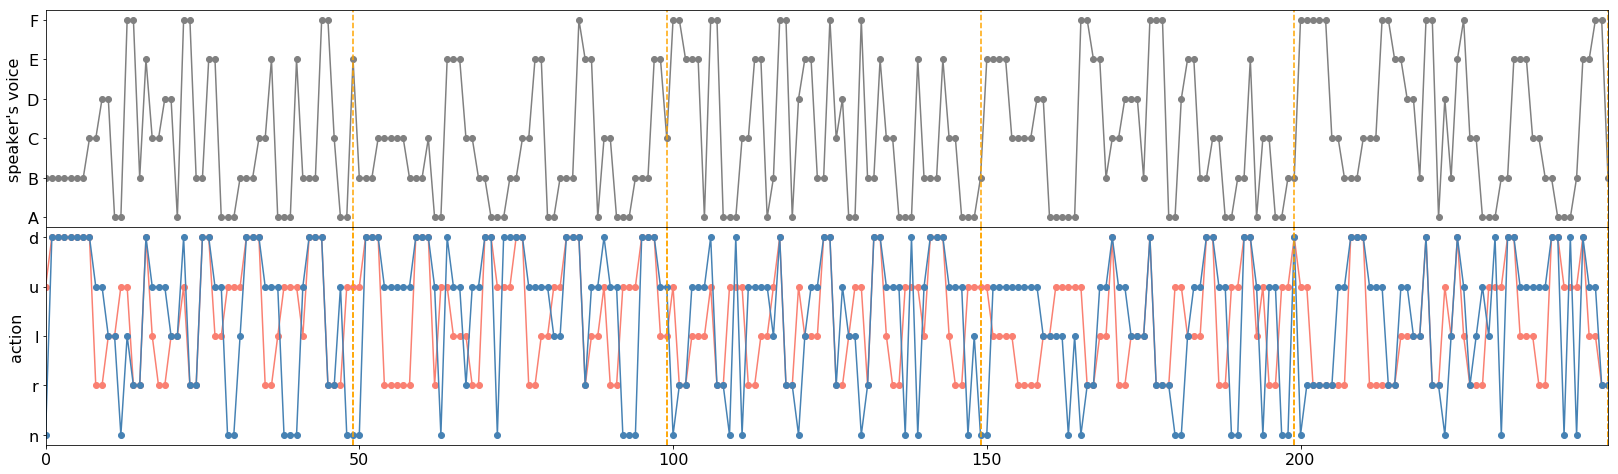

In [52]:
each_exp_dir= 'suikawari4__2018-04-04_13-46-22'
fn_video_template = 'video-{}.mp4'
epis = [50000]

each_exp_dir = osp.join(exp_dir, each_exp_dir)
display(plot_each_lc2(each_exp_dir))
plt.show()

for epi in epis:
    fn_video = fn_video_template.format(epi)
    display(play_linked_video(each_exp_dir, fn_video))
    plot_actions(epi, fn_video_template, n_episdoes=5, n_agents=3, n_dim_c=6)
    plt.show()